# Topic Modeling with Matrix Decomposition

#### Authors: Theophil Trippe and Sahil Karkhanis

In this Jupyter Notebook, we present an approach to Topic Modelling using a basic linear algebra concept called **Singular Value Decomposition** with a little demonstration. We took inspiration from the Numeric Linear Algebra course which was taught by Rachel Thomas at the University of San Francisco in 2017 and is available online: https://github.com/fastai/numerical-linear-algebra/tree/master/nbs . This notebook aims to give more insight into the topic and is written in order to allow an interactive familiarization with the concept.

## Introduction

![title](MatVellosoQuote.JPG)

### Topic Modelling: 
- NLP (Natural language processing) and 
- **not** Text Classification                       
    - supervised learning
    - you know topics beforehand
    - topics are cathegorize into those given topics
    - Naive Bayes, Support Vector Machines or logistic regression.
- Topic Modelling
    - unsupervised learning
    - learns topics (in form of weighted words)
    - learn a distribution of the documents into those topics
    - learns the overall relevance (across all documents) of each topic
    - allows quick classification of out-of-sample documents
                             
                             

#### Use Cases:

- Alternative to Text Classification when there is a lack of labeled data
- Client wants to analyze user requests (e.g. telecommunication company): 
 - *What* are the common topics concerning the customer? (e.g. billing, contract, service problems, etc.)
 - Do those topics *match* with the clients perception?
 - On what topics should the client allocate more capacities because the topic has a *high overall relevance*
 


## Data Preprocessing (Bag-of-Words approach)

Consider this dataset consisting of two documents where each document consists of just one sentence:

Document 1 | Document 2
---|---
This is a sentence about a dog. | Today we are talking about cats

The *bag-of-words* approach simply counts which word occurs how many times in a sentence. Therefore disregarding word-order or sentence structure:

Document 1 | Document 2
---|---
This is a sentence about a dog. | Today we are talking about cats
This (1) |
is (1) |
a (2) |
sentence (1) |
about (1) |
dog (1) |

Considering all documents, we obtain the vocabulary of our dataset and assign a value to each (word, document)-pair:

Vocabulary | Document 1 | Document 2
--- | ---|---
 | This is a sentence about a dog. | Today we are talking about cats
*This* | 1 | 0
*is* | 1 | 0
*a* | 2 | 0
*sentence* | 1 | 0
*about* | 1 | 1
*dog* | 1 | 0
*Today* | 0 | 1
*we* | 0 | 1
*are* | 0 | 1
*talking* | 0 | 1
*cats* | 0 | 1

We actually lose the information containing sentence structure and word-order of our documents completely, leaving us with a matrix containing all relevant information (here with an alphabetically ordered vocab):

Vocabulary | Document 1 | Document 2
--- | ---|---
*a* | 2 | 0
*about* | 1 | 1
*are* | 0 | 1
*cats* | 0 | 1
*dog* | 1 | 0
*is* | 1 | 0
*question* | 1 | 0
*talking* | 0 | 1
*this* | 1 | 0
*today* | 0 | 1
*we* | 0 | 1


## Our approach to Topic Modeling (SVD)

Once the data is transformed into a matrix, we use **Singular Value Decomposition (SVD)**, to decompose the matrix into three matrices $U, S$ and $V$. 

![title](SVD_visualization.jpg)

We can then interpret the different components of this new representation of our data in the following way:

+ **before**:  words per document

+ **after**:  (words per topic) (overall relevance of topics) (topics per document)

+ **columns of S**: topics, represented by the relevance of each word of the vocabulary

+ **columns of $\Sigma V$**: indexing the relative relevance of each topic for some specific document

## Demonstration


SciKitLearn provides build-in datasets: The **20 Newsgroups dataset** contains around 18000 newsgroup posts on 20 different topics. Newsgroups are discussion groupsin the Usenet, so you can think about it as internet forums.

In [1]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn import decomposition
from scipy import linalg
import matplotlib.pyplot as plt

%matplotlib inline
np.set_printoptions(suppress=True)

### Fetching and Cleaning the Data

There are roughly 11000 documents in the training data and 20 different topics:

In [2]:
example = fetch_20newsgroups()
print(example.filenames.shape)
example.target_names

(11314,)


['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

We will only use the data corresponding to 4 of those topics for the purpose of this demo.

In [3]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
example = fetch_20newsgroups(subset='train', categories=categories)

Looking at one of the documents we have now, we can see that there is still a lot of information that we don't need in the header and in the footer:

In [4]:
print("\n".join(example.data[:1]))

From: rych@festival.ed.ac.uk (R Hawkes)
Subject: 3DS: Where did all the texture rules go?
Lines: 21

Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych

Rycharde Hawkes				email: rych@festival.ed.ac.uk
Virtual Environment Laboratory
Dept. of Psychology			Tel  : +44 31 650 3426
Univ. of Edinburgh			Fax  : +44 31 667 0150



We can remove those automatically using the *remove* parameter included in fetch_20newsgroups.

In [5]:
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove= ('headers', 'footers', 'quotes')) #only the posts belonging to the specified cathegories where headers, footers and quotes are removed (cleaning the data) are included
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories,remove= ('headers', 'footers', 'quotes'))

The data now has a much cleaner look:

In [6]:
print("\n".join(newsgroups_train.data[:1]))

Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych


## Data Preprocessing

The next step will be, to transform each post into a vector. This step can be combined with other Data preprocessing. Some of the options are the following:


### Data Cleaning (Removing Stopwords and Stemming)
1. We can remove *stop-words*, so words (like "this", "and", "then", etc...) that don't provide insight about the occuring topics (in the bag of words approach, since we've lost the context of those words)

coming back to our previous example, it would reduce our data to this:

Vocabulary | Document 1 | Document 2
--- | ---|---
*cats* | 0 | 1
*dog* | 1 | 0
*question* | 1 | 0
*talking* | 0 | 1
*today* | 0 | 1


2. We can use a *stemmer*, which is an algorithm that reduces words to their stem (*e.g.: fisher, fishing, fished, fish $\rightarrow$ fish*) adding up the occuring instances of each version of the word


Those two operations drastically reduce the number of words in the vocabulary without losing information about the topics (assuming the stemmer works correctly), therefore improving the perfomance of the decomposition (later). There are several types of Stemming Algorithms that vary in terms of perfomance and accuracy.

### Vectorizing (using CountVectorizer or TfidfVectorizer)

Sklearn provides a few *vectorizer* as part of its feature_extraction tools to transform each document into a vector. (And therefore the dataset into a matrix.)
There are several ways to go, depending on the use case:

The straight forward approach (like in the cats and dogs example), is to simply count the number of appearances for each word, for that we can use the

3. a) Token counts:
      - **CountVectorizer**
      - straight forward
      - counts number of appearances of each word (in a specific document)
      - like in the cats and dogs example above
    
   b) Term frequency (adjusted for document length):
      - **TfidfVectorizer** with **use_idf = False**
      - Token counts devided by number of words in document
      - Use-case example: "Is a long and detailed user request more relevant than a short one?"
      - e.g. 10 documents, 9 with 50 words, 1 with 5000 words where *"fish"* appears 100 times: Are fish now an important topic overall or not?
 
   c) Term frequency and invers document frequency:
      - **TfidfVectorizer**
      - The weight of a word in a document is antiproportional to the amount of documents the word appears in
      - e.g. "the" may appear a lot in a document, but since that's the case for all documents, we should not give it too much weight
      - Use-case example: You may get a clearer distinction of topics for the different documents, but if a topic is relevant for many users, this approach would be hiding that fact.


---

### Some Possible Combinations

Here are just a few possible combinations, using the SnowballStemmer from nltk, note that the stemmer takes a few seconds to work its magic.

In [7]:
import nltk
# uncomment the following line for the first run.
#nltk.download('punkt') 

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


from nltk.tokenize import word_tokenize
from nltk.stem.snowball import EnglishStemmer

class SnowToke(object):
     def __init__(self):
        self.wnl = EnglishStemmer(ignore_stopwords=True)
     
     def __call__(self, doc):
        return [self.wnl.stem(t) for t in word_tokenize(doc)]

##### CountVectorizer (using stemming and discarding stop-words):

In [8]:
vectorizer1 = CountVectorizer(tokenizer= SnowToke(), stop_words= {'english'})
%time DocPerWord1 = vectorizer1.fit_transform(newsgroups_train.data).todense()
DocPerWord1.shape

Wall time: 9.18 s


(2034, 24800)

##### TfidfVectorizer (using stemming and discarding stop-words):

In [9]:
vectorizer2 = TfidfVectorizer(tokenizer= SnowToke(), stop_words= {'english'})
%time DocPerWord2 = vectorizer2.fit_transform(newsgroups_train.data).todense()
DocPerWord2.shape

Wall time: 10.1 s


(2034, 24800)

##### Term frequency adjusted for document length (using stemming and discarding stop-words):

In [10]:
vectorizer3 = TfidfVectorizer(tokenizer= SnowToke(), stop_words= {'english'}, use_idf=False)
%time DocPerWord3 = vectorizer3.fit_transform(newsgroups_train.data).todense()
DocPerWord3.shape

Wall time: 10.5 s


(2034, 24800)

##### CountVectorizer without stemming:

In [11]:
vectorizer4 = CountVectorizer(stop_words = 'english')
DocPerWord4= vectorizer4.fit_transform(newsgroups_train.data).todense() # (documents, vocab)
DocPerWord4.shape

(2034, 26576)

--------

The vectorizers used actually create a documents per words matrix. In order to comply with the schematic introduction above we need to transpose that matrix. *(Also choose which one of the options above you want to use to proceed)*

In [12]:
WordPerDoc = np.transpose(DocPerWord4)

Now *WordPerDoc* is the matrix, where the columns are the document-vectors.
since we have fitted the vectorizer we can also get the vocabulary in the same order (alphabetic) as associated in *vectors* :

In [13]:
vocab = np.array(vectorizer4.get_feature_names())
vocab.shape #contains the remaining vocabulary in the same order as the matrix


(26576,)

Let's have a look at the vocabulary:

In [14]:
vocab[9000:9020]

array(['egregious', 'egrep', 'egress', 'egret', 'egs', 'egsgate', 'egypt',
       'egyptian', 'egyptians', 'eh', 'ehb', 'eickemeyer', 'eicn',
       'eidetic', 'eiffel', 'eighth', 'eighties', 'eindprodukten',
       'eindstadia', 'einen'], dtype='<U80')

## Singular Value Decomposition
![title](SVD_visualization.jpg)
We can now get to the decomposition, using scipy.linalg's svd which does the job for us. Using *%time* we can see how long the calculation took:



In [15]:
%time U, S, V = linalg.svd(WordPerDoc, full_matrices=False)

Wall time: 25.1 s


In [16]:
print(U.shape, S.shape, V.shape)

(26576, 2034) (2034,) (2034, 2034)


we can see that apart from some numerical deviation, U,S,V really is a **decomposition** of our data matrix:

In [17]:
np.allclose(U @ np.diag(S) @ V, WordPerDoc)

True

Furthermore, the columns of $U$ are orthogonal, which is a mathematical way of saying that any two topics are maximally different:

In [18]:
np.allclose( np.transpose(U) @ U, np.eye(2034) ) 

True

At the moment we have 2034 topics for 2034 documents - which does not seem like a good way of modelling topics - but the model doesn't just assign a topic to each document, instead each document is composed of many different topics, each having an individual weight in that specific document. The overall relevance of each topic is encoded in $s$ and sorted in descending order:

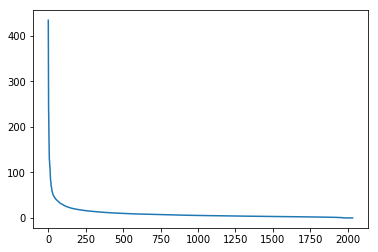

In [19]:
plt.plot(S)

We can see, that from the 2034 topics, only a fraction really has a relevant weight.

Let us have a look at the 10 most relevant topics found by our model, we will represent a topic by the 8 most relevant words to that topic:

In [20]:
def show_topics(a, num_top_words=8):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

In [21]:
show_topics(np.transpose(U)[:10])

['critus ditto propagandist surname galacticentric kindergarten surreal imaginative',
 'edu graphics data space pub mail 128 3d',
 'space jesus launch god people satellite matthew atheists',
 'space launch satellite commercial nasa satellites market year',
 'jpeg graphics space pub edu ray mail send',
 'jesus matthew prophecy messiah psalm isaiah david said',
 'launch commercial satellite market image services satellites launches',
 'data available nasa ftp grass anonymous contact gov',
 'atheists god religious atheism religion believe belief atheist',
 'probe data surface moon mars probes lunar launch']

Compare these topics with the *"original"* topics to see whether the results are good. Remember that this is unsupervised learning, the topics below are just for reference and have at no point been given to our model as information.

In [22]:
newsgroups_train.target_names #The original topics, for reference

['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']

Use the function below if you want to get more information on a specific topic. It gives you the number of top words you wish to see (default at 10) paired with their relevancy for the topic as well as a plot of those relevancies. Just put in the index of the topic you are interested in:

[(0.37078708261541204, 'space'),
 (0.23469791756443883, 'jesus'),
 (0.21631027095973063, 'launch'),
 (0.2025332575252736, 'god'),
 (0.13461498333108898, 'people'),
 (0.13006103023944154, 'satellite'),
 (0.12307802293069604, 'matthew'),
 (0.10973025494563006, 'atheists'),
 (0.09707589568187676, 'does'),
 (0.08698909373485755, 'time')]

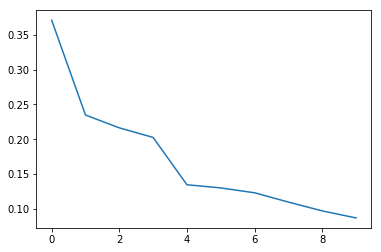

In [23]:
def topic_details(t, num_top_words=10):
    word_relev =  [(U[i,t],vocab[i]) for i in np.argsort(U[:,t])[:-num_top_words-1:-1]]
    display = [U[i,t] for i in np.argsort(U[:,t])[:-num_top_words-1:-1]]
    plt.plot(display)
    return word_relev

topic_details(2)

## Truncated SVD

Keeping the the relevancies of our topics in mind (plt.plot(S)), we can lose some of the less relevant topics, which translates into *truncating* our matrices $U, S$ and $V$. We get an approximate decomposition which uses way less space, called *Truncated SVD*. So we lose columns in $U$, singular values in $S$ and rows in $V$.

![title](SVD_visualization.jpg)

What happens, if we reduce $U$ by $n$ colons (from the right), $S$ by $n$ singular values (the last/least ones) and $V$ by $n$ rows (from the buttom)?

In [24]:
def truncate(n):
    U1 = U[:,:-n]
    S1 = S[:-n]
    V1 = V[:-n,0:]
    print(U1.shape, S1.shape, V1.shape)
    print("relative average deviation:" )
    return np.mean(WordPerDoc - (U1 @ np.diag(S1) @ V1))/np.mean(WordPerDoc)

In [25]:
truncate(2000)

(26576, 34) (34,) (34, 2034)
relative average deviation:


0.035640196139667964

So when losing 2000 of 2034 topics ( >98%) we only deviate by about 3.5% in average. What about the top 10 topics we had before?

In [26]:
truncate(2024)

(26576, 10) (10,) (10, 2034)
relative average deviation:


0.13880189087519487

So the top 10 topics cover more than 86% of the information troughout all documents. Other than interpretability of the topics, the relative average deviation might be a good percentage to try to minimize when you're interested in a certain number of topics.

## Randomized SVD

The runtime complexity of calculating the SVD of an $m \times n$ matrix is $\mathcal{O}(min(m^2n,n^2m))$. But as we saw above, we don't actually need to get all the topics. One way to drastically improve the performance with only a minor loss in accuracy is using randomized SVD, where you can decide upon the amount of topics you want to obtain:

In [27]:
u, s, v = decomposition.randomized_svd(WordPerDoc, 10)

In [28]:
print(u.shape,s.shape,v.shape)
np.mean(u@np.diag(s)@v - WordPerDoc)/np.mean(WordPerDoc)

(26576, 10) (10,) (10, 2034)


-0.13880258998375353

So we get an accuracy which is really close to where we computed the complete SVD and truncated it afterwards to the same number of topics. How do the topics in the randomized version look?

In [29]:
show_topics(np.transpose(u))

['jpeg image edu file graphics images gif data',
 'jpeg gif file color quality image jfif format',
 'space jesus launch god people satellite matthew atheists',
 'space launch satellite commercial nasa satellites market year',
 'image data processing analysis software available tools display',
 'jesus matthew prophecy messiah psalm isaiah david said',
 'launch commercial satellite market image services satellites launches',
 'image probe surface lunar mars probes moon orbit',
 'argument fallacy conclusion example true ad argumentum premises',
 'space larson image theory universe physical nasa material']

## Text Classification

The decomposition we have can not only give us a hold of the topics, in fact it comes with a decomposition right away.

The following function takes the index of a document as input and outputs the most relevant topics (5 at default) by displaying the overall topic nr., the relevancy for the specific document and the most relevant words for each topic (8 at default).

If details = True is set as a parameter, the relevancies of each word for a specific topic are also displayed and plotted.

With the *truncate_to* parameter, it can be specified how many of the (overall) most relevant topics should be taken into account.

Also *cl* should always be the matrix containing the topics-per-document matrix that takes the overall relevancies into account as well. 

In [39]:
cl = np.diag(S)@V

def show_classification(doc_index, num_top_words=8, num_topics=5, details=False, truncate_to=2000):
    topic_indexes = np.argsort(np.transpose(cl)[doc_index, :truncate_to],axis=None)  #get the indexes of the topics in descending order (in terms of relevancy for the document)
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]] #function that takes topic as input and returns top num_top_words words
    for i in range(num_topics): # i in [0,...,num_topics-1]
        cur_topic = topic_indexes[-(i+1)] #cur_topic = (i+1)-th most relevant topic
        print(str(i+1) +".) Topic id: " + str(cur_topic) + ", Topic relevancy for document:" + str(cl[cur_topic,doc_index]))
        if details:
            print(topic_details(cur_topic, num_top_words=num_top_words))
        else:
            print("Top " + str(num_top_words) + " words:") 
            print(' '.join(top_words(np.transpose(U)[cur_topic])))
    return 

### In-Sample data

Let's have a look at some the In-Sample document first:

In [40]:
print("\n".join(newsgroups_train.data[:1]))
show_classification(0, truncate_to=2000)
#show_classification(0, details=True)

Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych
1.) Topic id: 383, Topic relevancy for document:1.5076190369755713
Top 8 words:
read file koran linux mode given list interesting
2.) Topic id: 343, Topic relevancy for document:1.0248527983753972
Top 8 words:
aluminum video looking file polygon format email mr
3.) Topic id: 88, Topic relevancy for document:0.9361496911441157
Top 8 words:
bit cview xxxx sphinx believe does objective file


So we see that the text-classification results are actually not overwhelming in the sense that we don't see right asway that this post is related to computer graphics. But when looking at the keywords, we can see that most of them are indeed related to computer graphics. 

### Out-of-Sample data

But what happens when we use out-of-sample data? Rememember that the data we used was split into training- and testing- data. 
We can use the same vectorizer as before to transform the test data into a matrix. Note that any new vocabulary is lost in the process, so we might lose information on the topics during this step.

In [32]:
WordPerDoc_test = np.transpose(vectorizer4.transform(newsgroups_test.data)) #transform the test data into a matrix, using the vocab of the previous transformation
print(WordPerDoc_test.shape, WordPerDoc.shape)

(26576, 1353) (26576, 2034)


How do we get the classification now? It is actually really easy. if we have a document *doc* which translates into a document vector $b$, what we actually want to do is solve for $x$ the linear equation:

$b = Ux$

$x$ will then have the relevancies of the topics for *doc*. Solving that linear equation is actually really easy, because the columns of $U$ are orhogonal (as mentioned earlier), which means that: transpose(U) @ U = Identity. So

$x = transpose(U)b$

Let's have a look at one of the posts we have in the test data:

In [33]:
print("\n".join(newsgroups_test.data[2:3]))

Hi there,

I am here looking for some help.

My friend is a interior decor designer. He is from Thailand. He is
trying to find some graphics software on PC. Any suggestion on which
software to buy,where to buy and how much it costs ? He likes the most
sophisticated 
software(the more features it has,the better)


the corresponding document vector is the corresponding columns in *WordPerDoc_test*, so the topic-per-document vector is:

In [34]:
%time cl = np.transpose(U) @ WordPerDoc_test[:,2:3]

Wall time: 976 ms


We can now use function from before to have a look into that classification (it is important to set cl to the new topics-per-document vector/matrix for the function to work).

In [41]:
show_classification(0)

1.) Topic id: 383, Topic relevancy for document:1.5076190369755713
Top 8 words:
read file koran linux mode given list interesting
2.) Topic id: 343, Topic relevancy for document:1.0248527983753972
Top 8 words:
aluminum video looking file polygon format email mr
3.) Topic id: 88, Topic relevancy for document:0.9361496911441157
Top 8 words:
bit cview xxxx sphinx believe does objective file
4.) Topic id: 22, Topic relevancy for document:0.8860415274564906
Top 8 words:
edu read display menu bits faq program pressing
5.) Topic id: 259, Topic relevancy for document:0.884972801501304
Top 8 words:
actually isn points know vesa file sun member


So the classification seems to work quite well in the out-of-sample case as well.

## Conclusion

SVD is a very useful tool to do topic modelling which implicitly gives you a lot of information. Depending on the use-case, different preprocessing should be done. At all times it should be kept in mind that this is an unsupervised learning model and you therefore have to be more flexible in interpreting the results as compared to supervised learning.

There are other Matrix decompositions like Nonnegative Matrix Decompisition which can also be used for topic modelling but the fields of application are really only limited by your imagination, as SVD for instance can be used for background removal in videos and data compression.

Matrix Decomposition in general is a very basic yet powerfull concept, that can be implemented using open source toolkits and libraries and have direct real life use cases without needing any sophisticated deep learning models. These kind of mathematical (Linear Algebra) concepts are the basic fundamentals of AI.